In [153]:
import requests
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ensembl_rest as enr
import import_ipynb
import PlotComparingKallistoWithRSEM
from collections import defaultdict

In [168]:
class SeqLoader:
    """
    input:
    @GRCh37: bool
    """
    def __init__(self, GRCh37 = True):
        if GRCh37 == True:
            self.__server = "http://grch37.rest.ensembl.org"
            self.__ext = ""
            self.__seq = ""
            # self.__geneID = geneID
        
    def __loadSeq(self, geneID):
        self.__ext = "/sequence/id/{gene_id}?".format(gene_id = geneID)
        seq = requests.get(self.__server + self.__ext, headers={ 'content-Type' : 'text/plain'})
        if not seq.ok:
          seq.raise_for_status()
          sys.exit()
        self.__seq = seq.text
    
    def getSeq(self, geneID):
        self.__loadSeq(geneID)
        return self.__seq
    
    def countATGC(self, seq):
        """
        input:
        @seq: plain text sequence from loadSeq()
        
        return:
        a list of pertcentages of A, T, G, C and GC
        """
        dicA = defaultdict(int)
        dicT = defaultdict(int)
        dicG = defaultdict(int)
        dicC = defaultdict(int)
        seqLen = len(seq)
        for char in seq:
            if char == 'A':
                dicA['A'] = dicA['A'] + 1
            elif char == 'T':
                dicT['T'] = dicT['T'] + 1
            elif char == 'G':
                dicG['G'] = dicG['G'] + 1
            else:
                dicC['C'] = dicC['C'] + 1
        ratioA = dicA['A'] / seqLen
        ratioT = dicT['T'] / seqLen
        ratioG = dicG['G'] / seqLen
        ratioC = dicC['C'] / seqLen
        ratioGC = ratioG + ratioC
        print(ratioA)
        print(ratioT)
        print(ratioG)
        print(ratioC)
        print(ratioGC)
        return [ratioA, ratioT, ratioG, ratioC, ratioGC]

In [183]:
class CGREncoder:
    def __init__(self):
        self.__kmer_counts = None
        self.__kmer_prob = None
        self.__kmerSize = -1
        self.__matrixsize = -1
        self.__chaos = None
        
    def __kmerGenerator(self, seq, k):
        """
        input:
        @seq: string, a plain text sequence 
        @k: a positive integer
        
        return:
        self.__kmer: a dictionary with keys being the kmers, values being the counts of kmers
        """
        self.__kmer_counts = defaultdict(int)
        self.__kmer_prob = defaultdict(int)
        # print("Generating kmer pool")
        size = int(math.sqrt(4 ** k))
        self.__matrixsize = size
        self.__chaos = np.zeros((size, size), dtype = np.float)
        self.__kmerSize = len(seq) - k + 1
        for i in range(self.__kmerSize):
            self.__kmer_counts[seq[i : i + k]] += 1
            
        for key, value in self.__kmer_counts.items():
            self.__kmer_prob[key] = float(value) / (len(seq) - k + 1)
            
    def getKmerSize(self):
        return self.__kmerSize
    
    def getKmer(self):
        return [self.__kmer_counts, self.__kmer_prob]
    
    def encoding(self, seq, k):
        self.__kmerGenerator(seq, k)
        for key, value in self.__kmer_prob.items():
            minx = 0
            miny = 0
            maxx = self.__matrixsize - 1
            maxy = self.__matrixsize - 1
            midx = self.__midPoint(minx, maxx)
            midy = self.__midPoint(miny, maxy)
            charIdx = 0
            self.__helper(charIdx, minx, midx, maxx, miny, midy, maxy, key, value)
    
    def getChaosMatrix(self):
        return self.__chaos.copy()
    
    def __midPoint(self, small, large):
        return int(small + (large - small) / 2)
    
    def __helper(self, charIdx, minx, midx, maxx, miny, midy, maxy, key, value):
        if ((minx == maxx or miny == maxy) or charIdx >= len(key)):
            # idxx = self.__midPoint(minx, maxx)
            # idxy = self.__midPoint(miny, maxy)
            # print(idxy)
            # print(idxx)
            self.__chaos[minx][miny] = value
            return
        #print(key)
        char = key[charIdx]
        #print(char)
        charIdx = charIdx + 1
        if char == 'A':
            minx = minx
            maxx += midx
            miny = miny
            maxy += midy
            
        elif char == 'T':
            minx += midx
            maxx = maxx
            miny = miny
            maxy += midy
                
        elif char == 'G':
            minx += midx
            maxx = maxx
            miny += midy
            maxy = maxy
        else:
            minx = minx
            maxx += midx
            miny += midy
            maxy = maxy
        midx = self.__midPoint(minx, maxx)
        midy = self.__midPoint(miny, maxy)
       
        self.__helper(charIdx, minx, midx, maxx, miny, midy, maxy, key, value)

In [184]:
class EncodingTreatMent:
    __trtmnt = {'high': pd.read_csv('/home/lima/Project/simulation/Comparision/high.txt', skiprows = 0).values.tolist(),
                     'low': pd.read_csv('/home/lima/Project/simulation/Comparision/low.txt', skiprows = 0).values.tolist(),
                     'veh': pd.read_csv('/home/lima/Project/simulation/Comparision/veh.txt', skiprows = 0).values.tolist(),
                     'pt': pd.read_csv('/home/lima/Project/simulation/Comparision/pt.txt', skiprows = 0).values.tolist()}
    
    def __init__(self, trtmnt, normalized, cut):
        self.__loader = PlotComparingKallistoWithRSEM.DataLoader(trtmnt, normalized)
        # self.__kall = self.__loader.getKall()
        __temp = self.__loader.getRSEM()
        self.__rsem = __temp[cut]
        # print(self.__rsem)
        self.__genes = list(self.__rsem.index.values)
        # print(len(self.__genes))
        # self.__cut = cut
        self.__samples = self.__trtmnt[trtmnt]
        # print(self.__samples)
        self.__encoder = CGREncoder()
        self.__loader = SeqLoader()
        self.__result = {}
    
    def convert(self, k):
        for sample in self.__samples:
            __tmpDF = self.__rsem[sample]
            __tmpDict = {}
            for index in range(len(__tmpDF)):
                __gene = self.__genes[index]
                __tmpSeq = self.__loader.getSeq(__gene)
                self.__encoder.encoding(__gene, k)
                __tmpMatrix = self.__encoder.getChaosMatrix()
                __tmpMatrix = __tmpMatrix.reshape(1, 4 ** k)
                __tmpList = __tmpMatrix.tolist()
                __tmpDict[__gene]: __tmpList
            self.__result[sample]: __tmpDict
                    
    def getConvertedGroup(self):
        return self.__result

In [185]:
encoding = EncodingTreatMent('high', True, 5)
#encoding.convert(2)

In [ ]:
encoding.convert(2)

In [45]:
loader = SeqLoader(True, 'ENSG00000000419')
seq = loader.getSeq()

In [93]:
encoder = CGREncoder()
encoder.encoding(seq, 2)
twoMerMatrix = encoder.getChaoMatrix()

Generating kmer pool


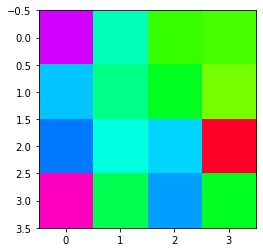

In [137]:
plt.imshow(twoMerMatrix, cmap = 'gist_rainbow', interpolation = 'nearest')

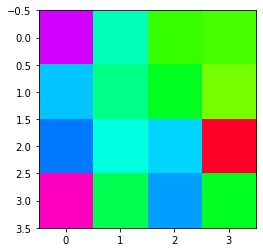

In [148]:
tenCounts = twoMerMatrix.copy()
tenCounts = tenCounts * 100
plt.imshow(tenCounts, cmap = 'gist_rainbow', interpolation = 'nearest')

In [149]:
tenCounts

array([[ 9.97973658,  6.31965552,  4.67747383,  4.56349206],
       [ 7.20618034,  5.96926714,  5.27693347,  4.24265451],
       [ 7.72965214,  6.61938534,  7.08797703,  1.25802094],
       [10.7311719 ,  5.59354948,  7.45947315,  5.28537656]])

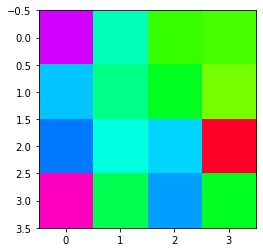

In [141]:
twelveCounts = twoMerMatrix.copy() * 12
plt.imshow(twelveCounts, cmap = 'gist_rainbow', interpolation = 'nearest')

In [133]:
a

array([[[0.99797366, 0.        , 0.        ],
        [0.63196555, 0.        , 0.        ],
        [0.46774738, 0.        , 0.        ],
        [0.45634921, 0.        , 0.        ]],

       [[0.72061803, 0.        , 0.        ],
        [0.59692671, 0.        , 0.        ],
        [0.52769335, 0.        , 0.        ],
        [0.42426545, 0.        , 0.        ]],

       [[0.77296521, 0.        , 0.        ],
        [0.66193853, 0.        , 0.        ],
        [0.7087977 , 0.        , 0.        ],
        [0.12580209, 0.        , 0.        ]],

       [[1.07311719, 0.        , 0.        ],
        [0.55935495, 0.        , 0.        ],
        [0.74594732, 0.        , 0.        ],
        [0.52853766, 0.        , 0.        ]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


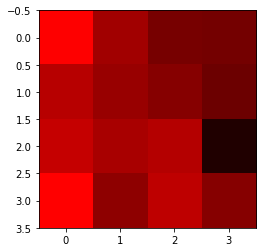

In [134]:
plt.imshow(a, interpolation = 'nearest')

In [121]:
r = np.random.random((4, 4, 3))
r

array([[[0.6966359 , 0.24318294, 0.63001438],
        [0.33406548, 0.11475653, 0.16019805],
        [0.03456886, 0.77926653, 0.40769478],
        [0.61271538, 0.09698737, 0.50692309]],

       [[0.13275995, 0.02130135, 0.4684711 ],
        [0.29340231, 0.8066627 , 0.98007332],
        [0.72138012, 0.04690557, 0.22317861],
        [0.64838108, 0.69015447, 0.97602366]],

       [[0.52543238, 0.39847798, 0.76298772],
        [0.56725618, 0.71021638, 0.64374852],
        [0.03524271, 0.58862015, 0.86654822],
        [0.06045062, 0.27024642, 0.63652811]],

       [[0.80746728, 0.73535455, 0.14714728],
        [0.7868474 , 0.21944319, 0.82687524],
        [0.78372735, 0.89403382, 0.51150047],
        [0.72283021, 0.5960279 , 0.28812859]]])

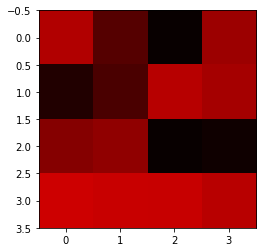

In [125]:
r[:, :, [1, 2]] = 0
plt.imshow(r, interpolation = 'nearest')

In [126]:
r[:, :, [1, 2]] = 0

In [127]:
r

array([[[0.6966359 , 0.        , 0.        ],
        [0.33406548, 0.        , 0.        ],
        [0.03456886, 0.        , 0.        ],
        [0.61271538, 0.        , 0.        ]],

       [[0.13275995, 0.        , 0.        ],
        [0.29340231, 0.        , 0.        ],
        [0.72138012, 0.        , 0.        ],
        [0.64838108, 0.        , 0.        ]],

       [[0.52543238, 0.        , 0.        ],
        [0.56725618, 0.        , 0.        ],
        [0.03524271, 0.        , 0.        ],
        [0.06045062, 0.        , 0.        ]],

       [[0.80746728, 0.        , 0.        ],
        [0.7868474 , 0.        , 0.        ],
        [0.78372735, 0.        , 0.        ],
        [0.72283021, 0.        , 0.        ]]])